In [78]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline



In [79]:
boston=pickle.load(open('boston_housing_clean.pickle', "rb" ))

In [80]:
boston.keys()

dict_keys(['dataframe', 'description'])

In [81]:
boston_data=boston['dataframe']
boston_description=boston['description']

In [82]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [83]:
X= boston_data.drop('MEDV', axis=1)
y=boston_data.MEDV

In [84]:
kf= KFold(shuffle=True, random_state=72018, n_splits=3)

In [85]:
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [ 1  3  4  5  7  8 10 11 12 13] 337
Test index: [ 0  2  6  9 15 17 19 23 25 26] 169

Train index: [ 0  2  6  9 10 11 12 13 15 17] 337
Test index: [ 1  3  4  5  7  8 14 16 22 27] 169

Train index: [0 1 2 3 4 5 6 7 8 9] 338
Test index: [10 11 12 13 18 20 21 24 28 31] 168



In [86]:
scores=[]
lr=LinearRegression()
for train_index, test_index in kf.split(X):
    
    X_train, X_test, y_train, y_test=(X.iloc[train_index, :],
                                       X.iloc[test_index,:], y[train_index], y[test_index])
    lr.fit(X_train, y_train)
    
    y_pred=lr.predict(X_test)
    
    score=r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
    score


In [87]:
print(scores)

[0.6719348798472755, 0.7485020059212368, 0.6976807323597749]


In [88]:
# for oscaling our data

scores=[]
lr=LinearRegression()
s=StandardScaler()

for train_index, test_index in kf.split(X):
    
    X_train, X_test, y_train, y_test=(X.iloc[train_index, :],
                                    X.iloc[test_index,:],
                                      y[train_index], 
                                      y[test_index])
    X_train_s=s.fit_transform(X_train)
    
    lr.fit(X_train_s, y_train)
    
    X_test_s= s.transform(X_test)
    
    
    y_pred=lr.predict(X_test_s)
    
    score= r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
    score

In [89]:
print(scores)

[0.6719348798472713, 0.748502005921238, 0.6976807323597742]


Pipeline and cross_val_predict

In [90]:
s= StandardScaler()
lr=LinearRegression()

In [91]:
estimator= Pipeline([("scaler",s),("regression",lr)])

cross_val_predict---is a function that does k-fold cross validation

In [92]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

In [93]:
predictions=cross_val_predict(estimator, X,y, cv=kf)

In [94]:
len(predictions)

506

In [95]:
r2_score(y,predictions)

0.7063531064161559

In [96]:
np.mean(scores) #almost identical!

0.7060392060427612

Hyperparameter tuning--involves using cross valaidation to determine hyperparameters likely to generate model that generates well outside the your sample

In [97]:
np.geomspace(1,27,4)

array([ 1.,  3.,  9., 27.])

In [98]:
alphas=np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

In [99]:
score=[]
coefs=[]
for alpha in alphas:
    las=Lasso(alpha=alpha, max_iter=100000)
    
    estimator=Pipeline([("scaler", s), ("lasso_regression", las)])
    
    predictions=cross_val_predict(estimator, X, y,cv=kf)
    
    score= r2_score(y, predictions)
    
    scores.append(score)

In [100]:
list(zip(alphas, scores))

[(1e-09, 0.6719348798472713),
 (1e-08, 0.748502005921238),
 (1e-07, 0.6976807323597742),
 (1e-06, 0.7063531064981925),
 (1e-05, 0.7063531072356071),
 (0.0001, 0.7063531145602441),
 (0.001, 0.7063531882052065),
 (0.01, 0.7063539165191507),
 (0.1, 0.706361268093463),
 (1.0, 0.706433467041546)]

In [101]:
Lasso(alpha=1e-6).fit(X,y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

In [102]:
Lasso(alpha=1.0).fit(X,y).coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

ValueError: x and y must have same first dimension, but have shapes (10,) and (13,)

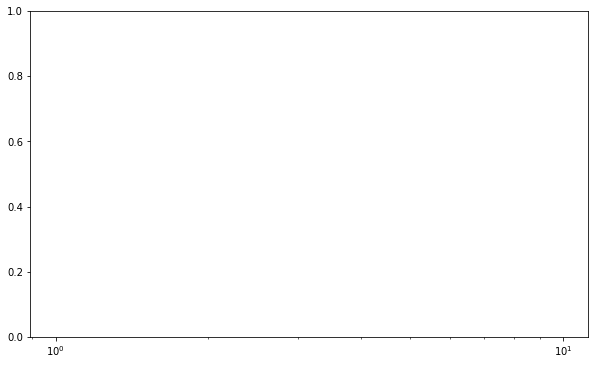

In [103]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-0')
plt.xlabel('$\\alpha$')
plt.ylabel('$R 2$')

Adding polynomial Features to this pipeline

In [104]:
pf= PolynomialFeatures(degree=3)

scores=[]
alphas=np.geomspace(0.001,10,5)
for alpha in alphas: 
                    
    las=Lasso(alpha=alpha, max_iter=100000)
                    
    estimator = Pipeline([("Make_higher_degreee", pf), ("scaler", s), ("lasso_regression",las)])
                    
    predictions=cross_val_predict(estimator, X, y,cv=kf)
    
    score= r2_score(y, predictions)
    
    scores.append(score)
    
                
                    
                    

C:\Users\Anuradha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.838350315724256, tolerance: 2.73469821958457
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anuradha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.426982961073804, tolerance: 2.777101952522255
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anuradha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.85300036827084, tolerance: 3.030405585798816
  model = cd_fast.enet_coordinate_descent(


In [105]:
alphas


array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [106]:
scores

[0.7697086980422645,
 0.8591002095361692,
 0.8280423631185616,
 0.7328688516176427,
 -0.000616160136140298]

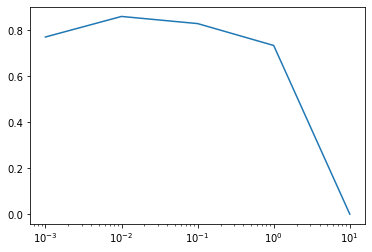

In [108]:
plt.semilogx(alphas, scores)

In [109]:
best_estimator = Pipeline([("Make_higher_degreee", PolynomialFeatures(degree=2)), ("scaler", s), ("lasso_regression", Lasso(alpha=0.01, max_iter=10000))])

best_estimator.fit(X,y)

best_estimator.score(X,y)
                    

0.9032551408154245

In [110]:
best_estimator.named_steps["lasso_regression"].coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        4.61127587e+00,  0.00000000e+00,  6.24240557e-01,  0.00000000e+00,
       -7.22878514e+00,  9.74968793e+00,  0.00000000e+00,  0.00000000e+00,
        6.34548325e-01,  0.00000000e+00,  9.95741679e-01, -5.51374291e-03,
       -0.00000000e+00,  2.44370838e+00, -2.40444044e+00, -0.00000000e+00,
       -0.00000000e+00, -2.23044443e-01, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -2.88128934e-01,  5.17203914e-01,  3.07715719e-01,
       -3.39853933e-01, -9.86590910e-02, -0.00000000e+00,  2.72847487e-01,
       -0.00000000e+00, -6.39829763e-01, -3.16474346e-01,  1.44555554e+00,
        0.00000000e+00, -0.00000000e+00, -8.84630187e-01,  1.32081558e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  2.63148300e+00,
       -2.62941147e-01,  0.00000000e+00,  9.08410143e-01, -8.17144528e-01,
        0.00000000e+00, -4.31628234e+00,  5.53254405e-01, -2.91912598e+00,
       -4.68486241e+00,  

Ridge regression

In [115]:
pf = PolynomialFeatures(degree=2)

alphas = np.geomspace(0.1, 2, 20)
scores=[]
for alpha in alphas: 
                    
    ridge = Ridge(alpha=alpha, max_iter=100000)
                    
    estimator = Pipeline([("polynomial_features", pf), ("scaler", s), ("ridge_regression",ridge)])
                    
    predictions = cross_val_predict(estimator, X, y,cv=kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)
    
    

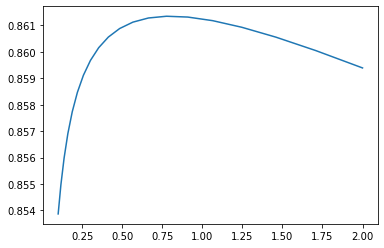

In [116]:
plt.plot(alphas, scores)